# US Name
Model estimate Estimate sign of effect


# Description

None

# Metadata

- Key: 242_esg_metadata 
- Epic: Models
- US: Estimate sign of effect
- Task tag: #draft, #polymer, #sign-of-effect
- Analytics reports: 

# Input

## Table/file

**Name**

None

**Github**

- https://github.com/thomaspernet/esg_metadata/blob/master/02_data_analysis/01_model_train_evaluate/01_sign_of_effect/00_sign_of_effect_classification.md



# Connexion server

In [93]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, shutil, json
import sys
import janitor

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-2'
bucket = 'datalake-london'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'esg'
table = 'meta_analysis_esg_cfp'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)',
                         'varchar(3)',
                        'varchar(14)', 'varchar(11)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [54]:
download_data = True
filename = "df_{}".format(table)
full_path_filename = "SQL_OUTPUT_ATHENA/CSV/{}.csv".format(filename)
path_local = os.path.join(
    str(Path(path).parent.parent.parent), "00_data_catalog/temporary_local_data"
)
df_path = os.path.join(path_local, filename + ".csv")
if download_data:

    s3 = service_s3.connect_S3(client=client, bucket=bucket, verbose=False)
    query = """
    WITH test as (
  SELECT 
    *, concat(environmental,  social, governance) as filters
  FROM esg.meta_analysis_esg_cfp
  WHERE 
    first_date_of_observations IS NOT NULL 
    and last_date_of_observations IS NOT NULL 
    and adjusted_model != 'TO_REMOVE' 
) 
SELECT 
  filters,
 paperid,
 nb_authors,
 reference_count,
 citation_count,
 influential_citation_count,
  CASE WHEN is_open_access = TRUE THEN 'YES' ELSE 'NO' END AS is_open_access,
 total_paper,
 esg,
 pct_esg,
 test.id_source,
 female,
 male,
 unknown,
 pct_female,
 drive_url,
 image,
 row_id_google_spreadsheet,
 table_refer,
 adjusted_model,
 adjusted_dependent,
 adjusted_independent,
 social,
 environmental,
 governance,
 lag,
 interaction_term,
 quadratic_term,
 n,
 target,
 adjusted_standard_error,
 adjusted_t_value,
 paper_name,
 first_date_of_observations,
 last_date_of_observations,
 csr_20_categories,
 kyoto,
 financial_crisis,
 windows,
 mid_year,
 regions,
 providers,
 publication_year,
 publication_name,
 rank_digit,
 CASE WHEN cluster_w_emb = 0 THEN 'CLUSTER_0'
       WHEN cluster_w_emb = 1 THEN 'CLUSTER_1'
       ELSE 'CLUSTER_2' END AS cluster_w_emb,
 sentiment,
 lenght,
 adj,
 noun,
 verb,
 size_abstract,
 pct_adj,
 pct_noun,
 pct_verb,
 rank,
 sjr,
 region_journal,
 weight
FROM 
  test 
  LEFT JOIN (
    SELECT 
      id_source, 
      COUNT(*) as weight 
    FROM 
      test 
    GROUP BY 
      id_source
  ) as c on test.id_source = c.id_source
  WHERE filters != 'TrueTrueTrue' and filters != 'FalseFalseFalse' and regions != 'ARAB WORLD'
    """.format(
        db, table
    )
    try:
        df = (s3.run_query(
            query=query,
            database=db,
            s3_output="SQL_OUTPUT_ATHENA",
            filename=filename,  # Add filename to print dataframe
            destination_key="SQL_OUTPUT_ATHENA/CSV",  # Use it temporarily
            dtype=dtypes,
        ).assign(
            d_rank_digit=lambda x: np.where(
                x["rank_digit"].isin(["1"]), "rank_1", "rank_2345"
            ),
            publication_year_int=lambda x: pd.factorize(x["publication_year"])[0],
        ))
    except:
        pass
(df.to_csv(os.path.join(path_local, "df_meta_analysis_esg_cfp" + ".csv")))
df = pd.read_csv(os.path.join(path_local, "df_meta_analysis_esg_cfp" + ".csv"))

In [55]:
df.shape

(534, 62)

In [56]:
pd.DataFrame(schema)

,Name,Type,Comment
0,paperid,string,paperid
1,nb_authors,int,nb authors
2,reference_count,int,reference count
3,citation_count,int,citation count
4,influential_citation_count,int,influential citation count
5,is_open_access,boolean,is open access
6,total_paper,int,total paper
7,esg,int,esg
8,pct_esg,float,pct esg
9,id_source,string,id source


### Save data to Google Spreadsheet

Data is in [METADATA_MODEL-FINAL_DATA](https://docs.google.com/spreadsheets/d/13gpRy93l7POWGe-rKjytt7KWOcD1oSLACngTEpuqCTg/edit#gid=1219457110)

In [10]:
#!pip install --upgrade git+git://github.com/thomaspernet/GoogleDrive-python

In [11]:
try:
    os.mkdir(os.path.join(os.getcwd(),"creds"))
except:
    pass

s3.download_file(key = "CREDS/Financial_dependency_pollution/creds/token.pickle",
                     path_local = "creds")

In [12]:
from GoogleDrivePy.google_drive import connect_drive
from GoogleDrivePy.google_authorization import authorization_service
import os
import shutil
import pandas as pd
from pathlib import Path

auth = authorization_service.get_authorization(
        path_credential_gcp=os.path.join(os.getcwd(), "creds", "service.json"),
        path_credential_drive=os.path.join(os.getcwd(), "creds"),
        verbose=False,
        scope=['https://www.googleapis.com/auth/spreadsheets.readonly',
               "https://www.googleapis.com/auth/drive"]
    )
gd_auth = auth.authorization_drive(path_secret=os.path.join(
        os.getcwd(), "creds", "credentials.json"))
drive = connect_drive.drive_operations(gd_auth)
shutil.rmtree(os.path.join(os.getcwd(),"creds"))

move_g_spreadsheet = False
if move_g_spreadsheet:
    FILENAME_SPREADSHEET = "METADATA_MODEL"
    spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)

    path_local = os.path.join(str(Path(os.getcwd()).parent.parent.parent), 
                                  "00_data_catalog/temporary_local_data")
    output = pd.read_csv( os.path.join(path_local, 'df_meta_analysis_esg_cfp' + '.csv'))
    drive.add_data_to_spreadsheet(
        data =output.fillna(""),
        sheetID =spreadsheet_id,
        sheetName = "FINAL_DATA",
        detectRange = True,
        rangeData = None)

# Statisitcs

## Basic information

- Number of observations

In [13]:
df.shape[0]

534

- Number of Journals

In [14]:
df['publication_name'].nunique()

32

- Number of publications

In [15]:
df['paperid'].nunique()

65

- Number of Authors

In [16]:
FILENAME_SPREADSHEET = "AUTHOR_SEMANTIC_GOOGLE"
spreadsheet_id = drive.find_file_id(FILENAME_SPREADSHEET, to_print=False)
df_author = (
    drive.download_data_from_spreadsheet(
    sheetID = spreadsheet_id,
    sheetName = "Sheet1",
    to_dataframe = True)
    .to_csv('temp_author.csv', index= False)
)

In [17]:
(
    pd.read_csv('temp_author.csv')
    .loc[lambda x: x['paperId'].isin(df['paperid'].unique())]
    .reindex(columns = ['name'])
    .drop_duplicates()
    .count()
)

name    169
dtype: int64

- Number of papers per author

In [18]:
(
    pd.read_csv('temp_author.csv')
    .loc[lambda x: x['paperId'].isin(df['paperid'].unique())]
    .groupby('name')
    .agg(
    {
        'paperId':'nunique'
    })
    .sort_values(by = ['paperId'])
    .groupby('paperId')
    .agg(
        {
            'paperId':'count'
        }
    )
    
)

,paperId
paperId,
1,163
2,6


- unbalanced ID

<AxesSubplot:ylabel='Frequency'>

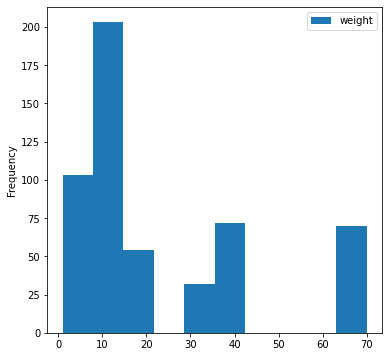

In [19]:
(
    df
    .reindex(columns = ['weight'])
    .plot
    .hist(5, figsize= (6,6))
)

<AxesSubplot:title={'center':'cumulated number of observations per paper'}>

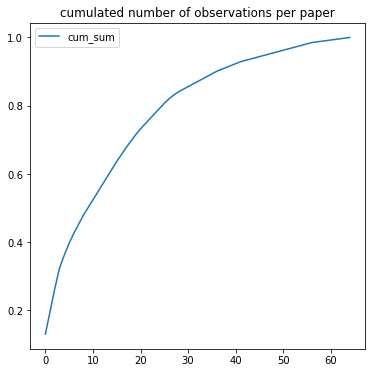

In [20]:
(
    (df.groupby('id_source')['id_source'].count()/df.shape[0]).rename("count")
    .reset_index()
    .sort_values(by = ['count'], ascending = False)
    .assign(cum_sum = lambda x: x['count'].cumsum())
    .reset_index()
    .drop(columns = ['index', 'count', 'id_source'])
    .plot
    .line(title = "cumulated number of observations per paper",figsize= (6,6))
    
    #.head(10)
)

## Statistic baseline

- environmental 
- social 
- governance
- adjusted_model  
- kyoto 
- financial_crisis
- publication_year
- windows
- mid_year
- regions
- sjr
- is_open_access
- region_journal
- providers

In [21]:
for v in [
    "target",
    "environmental",
    "social",
    "governance",
    "adjusted_model",
    "kyoto",
    "financial_crisis",
    "publication_year",
    "regions",
    "is_open_access",
    "region_journal",
    "providers",
]:
    print("\n\nDisplay variable: {}\n\n".format(v))
    display(
        pd.concat([df[v].value_counts(), df[v].value_counts(normalize=True)], axis=1)
    )



Display variable: target




,target,target
SIGNIFICANT,280,0.524345
NOT_SIGNIFICANT,254,0.475655




Display variable: environmental




,environmental,environmental
NO,418,0.782772
YES,116,0.217228




Display variable: social




,social,social
YES,364,0.681648
NO,170,0.318352




Display variable: governance




,governance,governance
NO,506,0.947566
YES,28,0.052434




Display variable: adjusted_model




,adjusted_model,adjusted_model
FIXED EFFECT,238,0.445693
POOLED OLS,137,0.256554
OTHER,66,0.123596
LAG DEPENDENT,39,0.073034
RANDOM EFFECT,31,0.058052
DIFF IN DIFF,12,0.022472
INSTRUMENT,11,0.020599




Display variable: kyoto




,kyoto,kyoto
YES,404,0.756554
NO,130,0.243446




Display variable: financial_crisis




,financial_crisis,financial_crisis
NO,478,0.895131
YES,56,0.104869




Display variable: publication_year




,publication_year,publication_year
2017,106,0.198502
2019,70,0.131086
2010,60,0.112360
2009,49,0.091760
2020,46,0.086142
2014,40,0.074906
2008,36,0.067416
2018,26,0.048689
2016,25,0.046816
2015,15,0.028090




Display variable: regions




,regions,regions
WORLDWIDE,283,0.529963
NORTH AMERICA,118,0.220974
EUROPE,57,0.106742
AFRICA,56,0.104869
LATIN AMERICA,20,0.037453




Display variable: is_open_access




,is_open_access,is_open_access
NO,352,0.659176
YES,182,0.340824




Display variable: region_journal




,region_journal,region_journal
EUROPE,484,0.906367
NORTHERN AMERICA,50,0.093633




Display variable: providers




,providers,providers
NOT_MSCI,310,0.580524
MSCI,224,0.419476


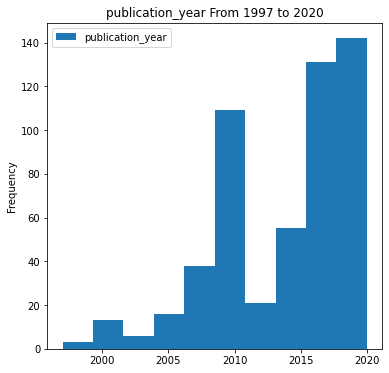

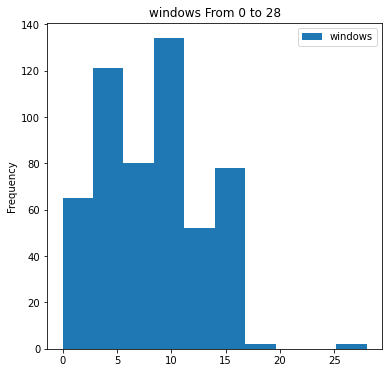

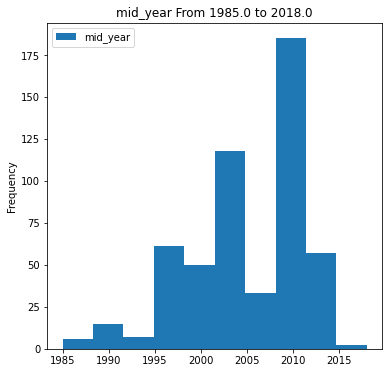

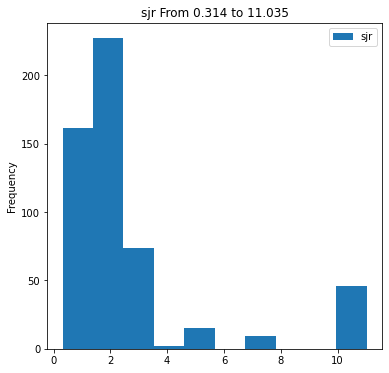

In [22]:
for v in ['publication_year', "windows", "mid_year", "sjr"]:
    #print("\n\nDisplay variable: {}\n\n".format(v))
    (
        df
        .reindex(columns = [v])
        .plot
        .hist(10, figsize= (6,6), title = "{} From {} to {}".format(
            v,
            df[v].min(),
            df[v].max()
        ))
    )

### Distribution baseline feature with target

"adjusted_model",  
"kyoto" ,
"financial_crisis",
"publication_year",
"windows",
"mid_year",
"regions",
"sjr",
"is_open_access",
"region_journal",
"providers"

#### environmental, social, governance

In [23]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("environmental")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "environment"}),
                            (
                                df.groupby("social")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "social"}),
                            (
                                df.groupby("governance")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "governance"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"environmental": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["environmental", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "environment"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["social", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "social"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["governance", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "governance"})
                                .unstack(0)
                            ),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"environmental": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target               NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin      is_dummy                                               
environment NO                   202         216        0.516746   
            YES                   52          64        0.551724   
social      NO                    85          85        0.500000   
            YES                  169         195        0.535714   
governance  NO                   237         269        0.531621   
            YES                   17          11        0.392857   

                         paper count                              
target               NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin      is_dummy                                              
environment NO                    37          53        0.588889  
            YES                   13          17        0.566667  
social      NO                    17          22        0.564103  
            YES                   33          50        0.602410  
governance  NO                    40          58        0.591837  
            YES                    4           4        0.500000

#### adjusted_model

In [24]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("adjusted_model")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "adjusted_model"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["adjusted_model", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "adjusted_model"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count  \
target                        NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
               adjusted_model                                               
adjusted_model DIFF IN DIFF                 8           4               1   
               FIXED EFFECT               105         133              17   
               INSTRUMENT                   5           6               2   
               LAG DEPENDENT               34           5               2   
               OTHER                       30          36              11   
               POOLED OLS                  64          73              13   
               RANDOM EFFECT                8          23               5   

                                                           
target                        SIGNIFICANT pct_significant  
               adjusted_model                              
adjusted_model DIFF IN DIFF             1        0.500000  
               FIXED EFFECT            24        0.585366  
               INSTRUMENT               4        0.666667  
               LAG DEPENDENT            2        0.500000  
               OTHER                   11        0.500000  
               POOLED OLS              20        0.606061  
               RANDOM EFFECT            8        0.615385

#### kyoto, financial_crisis

In [25]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("kyoto")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "kyoto"}),
                            (
                                df.groupby("financial_crisis")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "financial_crisis"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"kyoto": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["kyoto", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "kyoto"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["financial_crisis", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "financial_crisis"})
                                .unstack(0)
                            )
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"kyoto": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin           is_dummy                                               
kyoto            NO                    65          65        0.500000   
                 YES                  189         215        0.532178   
financial_crisis NO                   248         230        0.481172   
                 YES                    6          50        0.892857   

                              paper count                              
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin           is_dummy                                              
kyoto            NO                    14          18        0.562500  
                 YES                   28          42        0.600000  
financial_crisis NO                    40          51        0.560440  
                 YES                    2           9        0.818182

#### publication_year

In [26]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("publication_year")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "publication_year"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["publication_year", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "publication_year"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count  \
target                            NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
                 publication_year                                               
publication_year 1997                         NaN         3.0             NaN   
                 2000                         NaN         1.0             NaN   
                 2001                         8.0         4.0             1.0   
                 2002                         4.0         2.0             2.0   
                 2004                         5.0         1.0             2.0   
                 2005                         NaN         3.0             NaN   
                 2006                         1.0         6.0             1.0   
                 2007                         NaN         2.0             NaN   
                 2008                        15.0        21.0             5.0   
                 2009                        23.0        26.0             5.0   
                 2010                        34.0        26.0             4.0   
                 2011                         5.0         7.0             2.0   
                 2012                         1.0         7.0             1.0   
                 2013                         NaN         1.0             NaN   
                 2014                        22.0        18.0             2.0   
                 2015                         5.0        10.0             2.0   
                 2016                        13.0        12.0             3.0   
                 2017                        56.0        50.0             3.0   
                 2018                        10.0        16.0             2.0   
                 2019                        35.0        35.0             2.0   
                 2020                        17.0        29.0             5.0   

                                                               
target                            SIGNIFICANT pct_significant  
                 publication_year                              
publication_year 1997                     1.0        1.000000  
                 2000                     1.0        1.000000  
                 2001                     1.0        0.500000  
                 2002                     1.0        0.333333  
                 2004                     1.0        0.333333  
                 2005                     1.0        1.000000  
                 2006                     3.0        0.750000  
                 2007                     1.0        1.000000  
                 2008                     5.0        0.500000  
                 2009                     4.0        0.444444  
                 2010                     4.0        0.500000  
                 2011                     2.0        0.500000  
                 2012                     3.0        0.750000  
                 2013                     1.0        1.000000  
                 2014                     2.0        0.500000  
                 2015                     3.0        0.600000  
                 2016                     4.0        0.571429  
                 2017                     5.0        0.625000  
                 2018                     3.0        0.600000  
                 2019                     5.0        0.714286  
                 2020                     9.0        0.642857

#### is_open_access

In [27]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("is_open_access")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "is_open_access"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["is_open_access", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "is_open_access"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count  \
target                        NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
               is_open_access                                               
is_open_access NO                         170         182              28   
               YES                         84          98              14   

                                                           
target                        SIGNIFICANT pct_significant  
               is_open_access                              
is_open_access NO                      38        0.575758  
               YES                     22        0.611111

#### region_journal

In [28]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("region_journal")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "region_journal"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["region_journal", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "region_journal"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count  \
target                          NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
               region_journal                                                 
region_journal EUROPE                       235         249              37   
               NORTHERN AMERICA              19          31               5   

                                                             
target                          SIGNIFICANT pct_significant  
               region_journal                                
region_journal EUROPE                    53        0.588889  
               NORTHERN AMERICA           7        0.583333

#### providers

In [29]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("providers")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "providers"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["providers", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "providers"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count              \
target              NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT SIGNIFICANT   
          providers                                                           
providers MSCI                  119         105              16          18   
          NOT_MSCI              135         175              26          42   

                                     
target              pct_significant  
          providers                  
providers MSCI             0.529412  
          NOT_MSCI         0.617647

#### regions

In [30]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("regions")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "regions"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["regions", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "regions"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count              \
target                NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT SIGNIFICANT   
        regions                                                                 
regions AFRICA                     25          31               7           9   
        EUROPE                     27          30               3           6   
        LATIN AMERICA               7          13               2           2   
        NORTH AMERICA              46          72              14          21   
        WORLDWIDE                 149         134              16          22   

                                       
target                pct_significant  
        regions                        
regions AFRICA               0.562500  
        EUROPE               0.666667  
        LATIN AMERICA        0.500000  
        NORTH AMERICA        0.600000  
        WORLDWIDE            0.578947

#### sjr

In [31]:
(df.groupby("target").agg({"sjr": "describe"}))

sjr                                                        
                 count      mean       std    min    25%    50%    75%     max
target                                                                        
NOT_SIGNIFICANT  254.0  2.672307  2.613476  0.327  1.339  1.937  3.328  11.035
SIGNIFICANT      280.0  2.840436  3.015061  0.314  1.283  1.937  3.328  11.035

#### CNRS

In [32]:
pd.concat(
    [
        (
            df.groupby("rank_digit").agg(
                {"publication_name": "nunique", "id_source": "count"}
            )
        ),
        (
            df.groupby(["rank_digit", "target"])
            .agg({"id_source": "nunique"})
            .rename(columns={"id_source": "rank_digit"})
            .unstack(-1)
            .assign(
                pct_significant=lambda x: x[("rank_digit", "SIGNIFICANT")]
                / x.sum(axis=1)
            )
        ),
    ],
    axis=1,
)

,publication_name,id_source,"(rank_digit, NOT_SIGNIFICANT)","(rank_digit, SIGNIFICANT)","(pct_significant, )"
rank_digit,,,,,
1,8,80,11,19,0.633333
2,8,184,11,12,0.521739
3,1,35,2,4,0.666667
4,3,20,3,3,0.500000
5,12,215,15,22,0.594595


In [33]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("d_rank_digit")
                    .agg({"target": "value_counts"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("target", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["d_rank_digit", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "d_rank_digit"})
                    .unstack(-1)
                    .assign(
                        pct_significant=lambda x: x[("d_rank_digit", "SIGNIFICANT")]
                        / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                                 paper count  \
                      target             pct_significant    d_rang_digit   
target       NOT_SIGNIFICANT SIGNIFICANT                 NOT_SIGNIFICANT   
d_rang_digit                                                               
rank_1                    28          52        0.650000              11   
rank_2345                226         228        0.502203              31   

                                          
                         pct_significant  
target       SIGNIFICANT                  
d_rang_digit                              
rank_1                19        0.633333  
rank_2345             41        0.569444

#### complexity model

- lag
- interaction_term
- quadratic_term

In [34]:
pd.concat(
    [
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby("lag")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "lag"}),
                            (
                                df.groupby("interaction_term")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "interaction_term"}),
                            (
                                df.groupby("quadratic_term")
                                .agg({"target": "value_counts"})
                                .unstack(0)
                            ).rename(columns={"target": "quadratic_term"}),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"lag": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    pd.concat(
                        [
                            (
                                df.groupby(["lag", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "lag"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["interaction_term", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "interaction_term"})
                                .unstack(0)
                            ),
                            (
                                df.groupby(["quadratic_term", "target"])
                                .agg({"id_source": "nunique"})
                                .rename(columns={"id_source": "quadratic_term"})
                                .unstack(0)
                            ),
                        ],
                        axis=1,
                    )
                    .T.reset_index()
                    .rename(columns={"lag": "is_dummy", "level_0": "origin"})
                    .set_index(["origin", "is_dummy"])
                    .assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                              \
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant   
origin           is_dummy                                               
lag              NO                   200         239        0.544419   
                 YES                   54          41        0.431579   
interaction_term NO                   180         224        0.554455   
                 NO                    31           4        0.114286   
                 YES                   43          52        0.547368   
quadratic_term   NO                   249         271        0.521154   
                 YES                    5           9        0.642857   

                              paper count                              
target                    NOT_SIGNIFICANT SIGNIFICANT pct_significant  
origin           is_dummy                                              
lag              NO                    36          50        0.581395  
                 YES                   10          13        0.565217  
interaction_term NO                    39          57        0.593750  
                 NO                     1           1        0.500000  
                 YES                    9           9        0.500000  
quadratic_term   NO                    42          59        0.584158  
                 YES                    2           4        0.666667

#### nb_authors, pct_female, pct_esg_1

In [35]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("nb_authors")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "nb_authors"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["nb_authors", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "nb_authors"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count              \
target                NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT SIGNIFICANT   
           nb_authors                                                           
nb_authors 1                        7          15               2           5   
           2                       76         107              16          24   
           3                      100          99              16          20   
           4                       56          52               6           9   
           5                       15           7               2           2   

                                       
target                pct_significant  
           nb_authors                  
nb_authors 1                 0.714286  
           2                 0.600000  
           3                 0.555556  
           4                 0.600000  
           5                 0.500000

In [36]:
(df.groupby("target").agg({"pct_female": "describe"}))

pct_female                                                  
                     count      mean       std  min  25%       50%  75%  max
target                                                                      
NOT_SIGNIFICANT      254.0  0.379921  0.312025  0.0  0.0  0.333333  0.5  1.0
SIGNIFICANT          280.0  0.334464  0.342790  0.0  0.0  0.291667  0.5  1.0

In [37]:
(df.groupby("target").agg({"pct_esg": "describe"}))

pct_esg                                                    \
                  count      mean       std       min       25%       50%   
target                                                                      
NOT_SIGNIFICANT   254.0  0.193399  0.114641  0.040000  0.106383  0.152838   
SIGNIFICANT       280.0  0.186887  0.119762  0.036145  0.106383  0.141414   

                                     
                      75%       max  
target                               
NOT_SIGNIFICANT  0.287356  0.529412  
SIGNIFICANT      0.217391  0.529412

#### sentiment, cluster_w_emb

In [38]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("sentiment")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "sentiment"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["sentiment", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "sentiment"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count              \
target              NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT SIGNIFICANT   
          sentiment                                                           
sentiment NEGATIVE              107         112              13          22   
          POSITIVE              147         168              29          38   

                                     
target              pct_significant  
          sentiment                  
sentiment NEGATIVE         0.628571  
          POSITIVE         0.567164

In [39]:
pd.concat(
    [
        pd.concat(
            [
                (
                    df.groupby("cluster_w_emb")
                    .agg({"target": "value_counts"})
                    .unstack(0)
                    .rename(columns={"target": "cluster_w_emb"})
                    .T
                )
            ],
            axis=1,
            keys=["count"],
        ),
        pd.concat(
            [
                (
                    df.groupby(["cluster_w_emb", "target"])
                    .agg({"id_source": "nunique"})
                    .rename(columns={"id_source": "cluster_w_emb"})
                    .unstack(0)
                    .T.assign(
                        pct_significant=lambda x: x[("SIGNIFICANT")] / x.sum(axis=1)
                    )
                )
            ],
            axis=1,
            keys=["paper count"],
        ),
    ],
    axis=1,
)

count                 paper count  \
target                      NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
              cluster_w_emb                                               
cluster_w_emb CLUSTER_0                  97          68              12   
              CLUSTER_1                  46          89              10   
              CLUSTER_2                 111         123              20   

                                                         
target                      SIGNIFICANT pct_significant  
              cluster_w_emb                              
cluster_w_emb CLUSTER_0              18        0.600000  
              CLUSTER_1              18        0.642857  
              CLUSTER_2              24        0.545455

In [67]:
(
            df.groupby(["cluster_w_emb", "environmental"])
            .agg({"target": "value_counts"})
            .unstack(0)
     .rename(columns={"target": "environmental"})
    .T
        )

environmental                            NO                         YES  \
target                      NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
              cluster_w_emb                                               
environmental CLUSTER_0                  77          56              20   
              CLUSTER_1                  39          73               7   
              CLUSTER_2                  86          87              25   

environmental                            
target                      SIGNIFICANT  
              cluster_w_emb              
environmental CLUSTER_0              12  
              CLUSTER_1              16  
              CLUSTER_2              36

In [70]:
pd.concat(
    [
        (
            df.groupby(["cluster_w_emb", "environmental"])
            .agg({"target": "value_counts"})
            .unstack(0)
            .rename(columns={"target": "environmental"})
            .T
        ),
        (
            df.groupby(["cluster_w_emb", "social"])
            .agg({"target": "value_counts"})
            .unstack(0)
            .rename(columns={"target": "social"})
            .T
        ),
        (
            df.groupby(["cluster_w_emb", "governance"])
            .agg({"target": "value_counts"})
            .unstack(0)
            .rename(columns={"target": "governance"})
            .T
        ),
    ],
    axis=0,
)

environmental                            NO                         YES  \
target                      NOT_SIGNIFICANT SIGNIFICANT NOT_SIGNIFICANT   
              cluster_w_emb                                               
environmental CLUSTER_0                  77          56              20   
              CLUSTER_1                  39          73               7   
              CLUSTER_2                  86          87              25   
social        CLUSTER_0                  36          14              61   
              CLUSTER_1                  22          28              24   
              CLUSTER_2                  27          43              84   
governance    CLUSTER_0                  87          66              10   
              CLUSTER_1                  40          81               6   
              CLUSTER_2                 110         122               1   

environmental                            
target                      SIGNIFICANT  
              cluster_w_emb              
environmental CLUSTER_0              12  
              CLUSTER_1              16  
              CLUSTER_2              36  
social        CLUSTER_0              54  
              CLUSTER_1              61  
              CLUSTER_2              80  
governance    CLUSTER_0               2  
              CLUSTER_1               8  
              CLUSTER_2               1

#### Correlation among covariates

- publication_year 

In [111]:
# Compute the correlation matrix
corr = (
    df
    .reindex(columns = [
        'publication_year',
        'mid_year',
        "sjr",
        "windows",
        "nb_authors",
        "pct_female",
        "pct_esg"
    ])
    .corr()
)
(
    corr
    .where(np.triu(np.ones_like(corr, dtype=bool)))
    .T
    .style
    .format("{0:,.2f}",na_rep="-")
    #.background_gradient()
    #.applymap(lambda x: 'color: transparent' if pd.isnull(x) else '')
)

,publication_year,mid_year,sjr,windows,nb_authors,pct_female,pct_esg
publication_year,1.00,-,-,-,-,-,-
mid_year,0.89,1.00,-,-,-,-,-
sjr,-0.23,-0.38,1.00,-,-,-,-
windows,0.22,-0.06,0.16,1.00,-,-,-
nb_authors,0.11,0.14,-0.02,-0.05,1.00,-,-
pct_female,0.07,-0.00,-0.00,-0.03,-0.10,1.00,-
pct_esg,0.03,0.04,-0.13,-0.01,-0.43,0.22,1.00


In [ ]:
np.triu(np.ones_like(corr, dtype=bool))

In [102]:
corr.where(np.triu(np.ones_like(corr, dtype=bool))).T

,publication_year,mid_year,sjr,windows,nb_authors,pct_female,pct_esg
publication_year,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
mid_year,0.885712,1.000000,NaN,NaN,NaN,NaN,NaN
sjr,-0.234871,-0.377244,1.000000,NaN,NaN,NaN,NaN
windows,0.221347,-0.059154,0.160791,1.000000,NaN,NaN,NaN
nb_authors,0.111879,0.137767,-0.020026,-0.052887,1.000000,NaN,NaN
pct_female,0.072781,-0.004913,-0.004146,-0.028559,-0.103178,1.000000,NaN
pct_esg,0.034631,0.036774,-0.133737,-0.007437,-0.426922,0.216823,1.0


<AxesSubplot:xlabel='mid_year', ylabel='publication_year'>

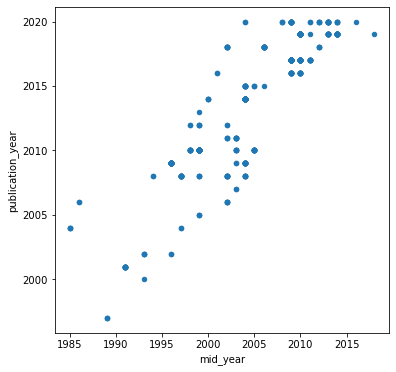

In [91]:
(
    df
    .reindex(columns = ['publication_year', 'mid_year'])
    .plot
    .scatter(x = 'mid_year', y = 'publication_year', figsize= (6,6) )
)

## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [40]:
add_to_dic = False
if add_to_dic:
    if os.path.exists("schema_table.json"):
        os.remove("schema_table.json")
    data = {'to_rename':[], 'to_remove':[]}
    dic_rename = [
        {
        'old':'working\_capital\_i',
        'new':'\\text{working capital}_i'
        },
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [41]:
sys.path.append(os.path.join(parent_path, 'utils'))
import latex.latex_beautify as lb
#%load_ext autoreload
#%autoreload 2

In [42]:
#!conda install -c conda-forge r-lmtest -y

In [43]:
options(warn=-1)
library(tidyverse)
library("sandwich")
library("lmtest")
#library(lfe)
#library(lazyeval)
#library(nnet)
library('progress')
path = "../../../utils/latex/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [77]:
%get df_path

normalit<-function(m){
   (m - min(m))/(max(m)-min(m))
 }
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%

mutate(
    adjusted_model = relevel(adjusted_model, ref='OTHER'),
    adjusted_dependent = relevel(adjusted_dependent, ref='OTHER'),
    id_source = as.factor(id_source),
    governance = relevel(as.factor(governance), ref = 'NO'),
    social = relevel(as.factor(social), ref = 'NO'),
    environmental =relevel(as.factor(environmental), ref = 'NO'),
    financial_crisis =relevel(as.factor(financial_crisis), ref = 'NO'),
    kyoto =relevel(as.factor(kyoto), ref = 'NO'),
    target =relevel(as.factor(target), ref = 'NOT_SIGNIFICANT'),
    regions =relevel(as.factor(regions), ref = 'WORLDWIDE'),
    is_open_access =relevel(as.factor(is_open_access), ref = 'NO'),
    sentiment =relevel(as.factor(sentiment), ref = 'NEGATIVE'),
    region_journal =relevel(as.factor(region_journal), ref = 'NORTHERN AMERICA'),
    pct_esg_1 = normalit(pct_esg),
    esg_1 =  normalit(esg),
    sjr_1 =  normalit(sjr),
    cluster_w_emb = relevel(as.factor(cluster_w_emb), ref = 'CLUSTER_1'),
    citation_count_1 = normalit(citation_count),
    providers = relevel(as.factor(providers), ref = 'NOT_MSCI'),
    d_rank_digit = relevel(as.factor(d_rank_digit), ref = 'rank_2345')
)

Parsed with column specification:
cols(
  .default = col_double(),
  filters = col_character(),
  paperid = col_character(),
  is_open_access = col_character(),
  drive_url = col_character(),
  image = col_character(),
  row_id_google_spreadsheet = col_character(),
  table_refer = col_character(),
  adjusted_model = col_character(),
  adjusted_dependent = col_character(),
  adjusted_independent = col_character(),
  social = col_character(),
  environmental = col_character(),
  governance = col_character(),
  lag = col_character(),
  interaction_term = col_character(),
  quadratic_term = col_character(),
  target = col_character(),
  paper_name = col_character(),
  csr_20_categories = col_character(),
  kyoto = col_character()
  # ... with 8 more columns
)
See spec(...) for full column specifications.


In [45]:
glimpse(df_final)

Observations: 534
Variables: 66
$ X1                         <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, …
$ filters                    <fct> NOYESNO, NOYESNO, NOYESNO, NOYESNO, NOYESN…
$ paperid                    <fct> 02281aebff7110c8b6efb59ebba448ecb7e2a4cc, …
$ nb_authors                 <dbl> 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, …
$ reference_count            <dbl> 303, 303, 300, 300, 300, 300, 300, 300, 30…
$ citation_count             <dbl> 1170, 1170, 21, 21, 21, 21, 21, 21, 21, 21…
$ influential_citation_count <dbl> 72, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ is_open_access             <fct> NO, NO, NO, NO, NO, NO, NO, NO, NO, NO, NO…
$ total_paper                <dbl> 197, 197, 255, 255, 255, 255, 255, 255, 25…
$ esg                        <dbl> 48, 48, 30, 30, 30, 30, 30, 30, 30, 30, 30…
$ pct_esg                    <dbl> 0.2436548, 0.2436548, 0.1176471, 0.1176471…
$ id_source                  <fct> 64, 64, 11, 11, 11, 11, 11, 11, 11, 11, 11…
$ female            

In [46]:
transpose(df_final %>% 
    select_if(function(x) any(is.na(x))) %>% 
    summarise_each(funs(sum(is.na(.)))))

[[1]]
[[1]]$image
[1] 139

[[1]]$adjusted_independent
[1] 17

[[1]]$n
[1] 6

[[1]]$adjusted_standard_error
[1] 73

[[1]]$adjusted_t_value
[1] 98

GLM does not clustered the standard error so, we compute it by hand

In [47]:
se_robust <- function(x)
  coeftest(x, vcov. = sandwich::sandwich
          )[, 2]

# Table 1: Probit

$$
\mathrm{P}\left(\text { Significant }_{\mathrm{ib}}=\mathrm{significant}\right)=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

- robust standard error
- Cannot compute clustered standard error if we add features without variation among the c luster (i.e `n`, or journal information)

## Variable construction


* Significant: If in the table, p-value below .1, then significant else not significant
* The variable adjusted_independent is too imbalanced, and we are interested in only:
  * SOCIAL
  * ENVIRONMENTAL
  * GOVERNANCE
- d_rang_digit: CNRS has 4 categories, ranging from 1 to 4. We added a 5th category for the missing one. The dummy compare the top journals (rank 1) vs. the others
* So need to create three underlying dummy variables: rules below
  * Source low-level variable: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=146632716&range=B126
  * SOCIAL if adjusted_independent : 
    * ENVIRONMENTAL AND SOCIAL
    * SOCIAL
    * CSP
    * CSR
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * ENVIRONMENTAL if adjusted_independent :
    * ENVIRONMENTAL
    * ENVIRONMENTAL AND SOCIAL
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
  * GOVERNANCE if adjusted_independent :
    * GOVERNANCE
    * ENVIRONMENTAL, SOCIAL and GOVERNANCE
- adjusted_model: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=793443705&range=B34
- adjusted_dependent: https://docs.google.com/spreadsheets/d/1d66_CVtWni7wmKlIMcpaoanvT2ghmjbXARiHgnLWvUw/edit#gid=450174628&range=B59
- Region:
    - AFRICA: 'Cameroon', 'Egypt', 'Libya', 'Morocco', 'Nigeria'
    - ASIA AND PACIFIC:  'India', 'Indonesia', 'Taiwan', 'Vietnam', 
        'Australia', 'China', 'Iran', 'Malaysia', 
        'Pakistan', 'South Korea', 'Bangladesh'
    - EUROPE: 'Spain', '20 European countries', 
        'United Kingdom', 'France', 'Germany, Italy, the Netherlands and United Kingdom', 
        'Turkey', 'UK'
    - LATIN AMERICA: 'Latin America', 'Brazil'
    - NORTH AMERICA: 'USA', 'US', 'U.S.', 'Canada'
    - ELSE WORLDWIDE
- Kyoto first_date_of_observations >= 1997 THEN TRUE ELSE FALSE ,
- Financial crisis first_date_of_observations >= 2009 THEN TRUE ELSE FALSE 
- windows: last_date_of_observations - first_date_of_observations
- mid-year: last_date_of_observations - (windows/2)
- is_open_access: True if the journal is an open access publication
- region_journal: Region journal
    - Europe
        - Eastern Europe
        - Western Europe
    - Northern America
- providers: If `csr_20_categories` equals to 'MSCI'  then "MCSI" else "NOT_MSCI". MSCI is the main ESG's data provider
- nb_authors: Number of authors
- pct_female: Percentage of female authors
- pct_esg_1: ESG expert score calculated as the number of publications labeled as ESG over the total number of publications for all the authors of the paper
- Sentiment: Overall feeling of the abstract. Positive means the abstract tend to have more words associated with a positive connotation
- cluster_w_emb: 3 clusters computed using the words in the abstract (embeddings), the number of verbs, noun,s and adjectives but also the size of the abstract. 


## note about Probit 

TO estimate a probit, use `probit` link function.  For logistic regression, use `binomial`

- Reason Probit instead of Logit
    - [What is the Difference Between Logit and Probit Models?](https://tutorials.methodsconsultants.com/posts/what-is-the-difference-between-logit-and-probit-models/)

Logit and probit differ in how they define $f(∗)$. The logit model uses something called the cumulative distribution function of the logistic distribution. The probit model uses something called the cumulative distribution function of the standard normal distribution to define $f(∗)$.

Probit models can be generalized to account for non-constant error variances in more advanced econometric settings (known as heteroskedastic probit models)

## How to read

**Comparison group**

- Always `OTHER`
- Target: `SIGNIFICANT`
- regions: `WORLDWIDE`
- cnrs_ranking: `0`

**Odd ratio**

- Categorical:
    - Keeping all other variables constant, if the analysis uses FIXED EFFECT model, there are 2.71 times more likely to stay in the NEGATIVE sign category as compared to the OTHER model category. The coefficient, however, is not significant. (Col 1)
- Continuous:
    - Keeping all other variables constant, if the SJR score increases one unit, there is 1.003 times more likely to stay in the POSITIVE sign category as compared to the OTHER model category y (the risk or odds is .2% higher). The coefficient is significant.
    
Here, OTHER means insignificant

### Baseline table

The baseline regression accounts for: 

```
environmental # social governance
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
```

In [48]:
### Baseline SJR
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_0.txt")


                                                    target                         
                              (1)      (2)      (3)       (4)       (5)      (6)   
-----------------------------------------------------------------------------------
environmentalYES            1.201***                    1.204***                   
                            (0.153)                     (0.159)                    
                                                                                   
socialYES                            1.047***                     1.059***         
                                     (0.144)                      (0.147)          
                                                                                   
governanceYES                                 0.964***                     0.984***
                                              (0.335)                      (0.342) 
                                                                           

In [49]:
### Baseline CNRS
t_0 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))
t_1 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_1.rrr <- exp(coef(t_1))
t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers,
           data = df_final , binomial(link = "probit"))
t_2.rrr <- exp(coef(t_2))
### Econometrics control
t_3 <- glm(target ~ environmental
           + adjusted_model  
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final ,
           binomial(link = "probit")
          )
t_3.rrr <- exp(coef(t_3))
t_4 <- glm(target ~ social
           + adjusted_model    
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_4.rrr <- exp(coef(t_4))
t_5 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final , binomial(link = "probit"))
t_5.rrr <- exp(coef(t_5))

list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
list_final.rrr = list(t_0.rrr,t_1.rrr ,t_2.rrr,t_3.rrr,t_4.rrr,t_5.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_1.txt")


                                                   target                        
                              (1)      (2)      (3)      (4)      (5)      (6)   
---------------------------------------------------------------------------------
environmentalYES            1.215***                   1.214***                  
                            (0.151)                    (0.158)                   
                                                                                 
socialYES                            1.039***                   1.053***         
                                     (0.143)                    (0.146)          
                                                                                 
governanceYES                                 0.938***                   0.960***
                                              (0.341)                    (0.349) 
                                                                                 
adjusted_modelD

### Papers and authors specification


In the second tables, we focus on the authors informations:

Baseline variables + 

- nb_authors: Number of authors in the paper
- pct_female: Percentage of female author
- pct_esg_1: ESG expertise of the authors (normalized value)



In [50]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_3.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.135***                              
                               (0.161)                              
                                                                    
socialYES                                   1.112***                
                                             (0.152)                
                                                                    
governanceYES                                             0.986***  
                                                          (0.359)   
                                                                    
adjusted_modelDIFF IN DIFF     1.141**       1.155**      1.137**   
                               (0.562)       (0.559)      (0.560)   
                                 

In [51]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_4.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.151***                              
                               (0.160)                              
                                                                    
socialYES                                   1.101***                
                                             (0.152)                
                                                                    
governanceYES                                             0.963***  
                                                          (0.364)   
                                                                    
adjusted_modelDIFF IN DIFF     1.057*        1.076*        1.060*   
                               (0.562)       (0.557)      (0.558)   
                                 

### Characteristic abstract

**Sentiment**: Overall feeling of the abstract. Positive means the abstract tend to have more words associated with a positive connotation

**cluster_w_emb**: 3 clusters computed using the words in the abstract (embeddings), the number of verbs, noun,s and adjectives but also the size of the abstract. 

The k-mean algorithm clustered the abstract based on the "quality" of it. 

- sentiment
- cluster

![](https://storage.googleapis.com/memvp-25499.appspot.com/images/image.png76221423-1aa4-4af3-a9e0-3a6b46b0c1f2)

In [79]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           #+ mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_6.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.219***                              
                               (0.160)                              
                                                                    
socialYES                                   1.065***                
                                             (0.149)                
                                                                    
governanceYES                                             0.885**   
                                                          (0.360)   
                                                                    
adjusted_modelDIFF IN DIFF     1.084**       1.078**      1.085**   
                               (0.547)       (0.541)      (0.540)   
                                 

In [53]:
###
t_0 <- glm(target ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_0.rrr <- exp(coef(t_0))


t_1 <- glm(target ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_1.rrr <- exp(coef(t_1))

t_2 <- glm(target ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rank_digit
           + is_open_access
           + region_journal
           + providers
           + sentiment
           + cluster_w_emb,
           data = df_final ,
           binomial(link = "probit")
          )
t_2.rrr <- exp(coef(t_2))

list_final = list(t_0, t_1, t_2)
list_final.rrr = list(t_0.rrr,t_1.rrr,t_2.rrr)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          coef=list_final.rrr,
          style = "qje",
         out="TABLES/table_5.txt")


                                             target                 
                                 (1)           (2)          (3)     
--------------------------------------------------------------------
environmentalYES              1.217***                              
                               (0.160)                              
                                                                    
socialYES                                   1.067***                
                                             (0.149)                
                                                                    
governanceYES                                             0.868**   
                                                          (0.365)   
                                                                    
adjusted_modelDIFF IN DIFF     1.048*        1.036*        1.042*   
                               (0.539)       (0.533)      (0.533)   
                                 

## Model OLS: 

$$
 \text{T-value}=\mathrm{\beta}_{0} + 
\mathrm{\beta}_{1}\text { ESG }_{\mathrm{ib}}+ 
\mathrm{\beta}_{2}\text { Kyoto }_{\mathrm{i}} +
\mathrm{\beta}_{3}\text { Financial crisis }_{\mathrm{i}} +
\mathrm{\beta}_{4}\text { Publication year }_{\mathrm{i}} + 
\mathrm{\beta}_{5}\text { windows }_{\mathrm{i}} +
\mathrm{\beta}_{6}\text { mid-year }_{\mathrm{i}} +
\mathrm{\beta}_{7}\text { region }_{\mathrm{ib}}
+\epsilon _{\mathrm{ib}}
$$

### Computation t-value

* construct should_t_value   equals to “TO_CHECK” → if test_standard_error   = “TO_CHECK” and adjusted_model  is not PANEL or POOLED (use panel because panel use clustered/robust standard error no direct computation), then check if switch standard error and t-stat, so use column sr has t-stat and compare with critical value. If match critical value, and equals to stars  then OK, else “TO_CHECK”
* Construct adjusted_standard_error : if test_standard_error  is OK and should_t_value  is NO_NEED_TO_CHECK then use sr , else leave blank
* Construct **adjusted_t_value**: 
  * ⚠️ critical value (the raw data has a column for the t_value which is similar, but the variable adjusted_t_value is reconstructed based on known t_value or in case of unknown t_value then from standard error or p-value: 
    * If test_t_value is equals to TO_CHECK or OK then use t_value ← We use the value reported in the paper, not the one reconstructed
    * ELSE if test_standard_error is equal to NO_SE and test_p_value is equal to OK then we can compute the critical value using the t-inverse function. 
      * Ex: round(T.INV(1-X114, I114) where X114 is the p-value, so we want to get the right tail. If p-value is .05, the the right tail is .95.
    * ELSE beta / standard error 
    * Note, if critical value cannot be computed, it is because of one of the following reason
      *  p-value is 0, then cannot compute the critical value
      * standard error is 0, cannot divide by 0
      * missing standard error, t-value or p-value
      
- Remove 10 outliers -> critical value more than 1K -> high leverage and does not represent the true data
- Standard error robust

Model 1: No absolute value

Interested in the magnitude of the t-student critical value

In [ ]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

In [ ]:
### Baseline SJR
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_2 <- glm(adjusted_t_value ~ governance
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

### Econometrics control
t_3 <- glm(adjusted_t_value ~ environmental
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_4 <- glm(adjusted_t_value ~ social
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))

t_5 <- glm(adjusted_t_value ~ governance
            + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + lag
           + interaction_term
           + quadratic_term,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity))


list_final = list(t_0, t_1, t_2, t_3, t_4, t_5)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

Author

In [ ]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

In [ ]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + nb_authors
           + pct_female
           + pct_esg_1,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

Abstract

In [ ]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + sjr
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

In [ ]:
###
t_0 <- glm(adjusted_t_value ~ environmental
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )
t_1 <- glm(adjusted_t_value ~ social
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

t_2 <- glm(adjusted_t_value ~ governance
           + adjusted_model
           + kyoto 
           + financial_crisis
           + publication_year_int
           + windows
           + mid_year
           + regions
           + d_rang_digit
           + is_open_access
           + region_journal
           + sentiment
           + cluster_w_emb,
           data = df_final %>% filter(adjusted_t_value < 10),
           family=gaussian(identity)
          )

list_final = list(t_0, t_1, t_2)
stargazer(list_final, type = "text", 
  se = lapply(list_final,
              se_robust),
          style = "qje")

# Generate reports

In [ ]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_report

In [ ]:
name_json = 'parameters_ETL_esg_metadata.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [ ]:
create_report.create_report(extension = "html", keep_code = True, notebookname = "00_sign_of_effect_classification.ipynb")

In [ ]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          #os.path.join(str(Path(path).parent), "00_download_data_from"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)